In [1]:
import arviz as az
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import matplotlib.pyplot as plt
import os
import bambi as bmb

In [2]:
OUTPUT_PATH  = os.getenv("OUTPUT_PATH")
SIPP_MODEL_DATA = "sipp_model.parquet"

In [3]:
sipp_model = pl.read_parquet(os.path.join(OUTPUT_PATH,SIPP_MODEL_DATA))
sipp_model

row_id,state,metro,hh_income,male,age,edu,race_eth,tenure,homevalue,disability,class_worker,household_type,citizen,english_at_home,public_assistance,social_security,poverty,hh_any_asset,hh_any_debt,hh_any_wealth,hh_assets,hh_debts,hh_networth,WPFINWGT,REPWGT0,REPWGT1,REPWGT2,REPWGT3,REPWGT4,REPWGT5,REPWGT6,REPWGT7,REPWGT8,REPWGT9,REPWGT10,REPWGT11,…,REPWGT207,REPWGT208,REPWGT209,REPWGT210,REPWGT211,REPWGT212,REPWGT213,REPWGT214,REPWGT215,REPWGT216,REPWGT217,REPWGT218,REPWGT219,REPWGT220,REPWGT221,REPWGT222,REPWGT223,REPWGT224,REPWGT225,REPWGT226,REPWGT227,REPWGT228,REPWGT229,REPWGT230,REPWGT231,REPWGT232,REPWGT233,REPWGT234,REPWGT235,REPWGT236,REPWGT237,REPWGT238,REPWGT239,REPWGT240,prank_assets,prank_debts,prank_networth
u32,i64,i8,i32,i32,i8,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,i8,i8,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,20,1,5,1,4,1,3,3,1,0,3,4,1,1,0,0,0,0,0,0,null,null,null,5989.598574,5989.598574,8954.586112,8849.341704,8797.592457,10319.170027,3275.925917,8770.842073,9066.189337,9010.867384,8659.739497,8585.127515,3206.950149,…,9539.53928,3359.917137,9357.597513,3060.681297,9312.310012,3028.292811,3138.755029,3107.838152,9349.057103,3027.382882,2954.389298,3315.789779,8963.345575,3064.199956,8613.181223,3298.967741,8601.634345,7999.729342,8610.6132,8898.586021,2891.721347,2777.848517,3186.551044,9267.562377,9525.445889,2835.250575,3376.516573,8676.297647,2727.976942,10088.098598,8656.516283,3070.828503,9560.724063,2879.528162,null,null,null
1,20,1,8,0,5,3,1,2,4,0,3,4,1,1,0,0,0,1,1,1,102730.0,72400.0,30330.0,3904.848315,3904.848315,6330.543325,4918.597457,5401.319123,5421.492964,2153.493717,5255.293637,5467.909925,6084.953855,5730.943657,5939.862118,1955.644305,…,5546.387613,2127.503751,6720.71101,1830.579265,5489.736664,2068.422888,1975.42355,2030.988404,6307.473333,1942.433193,2119.051039,2127.77716,5395.058699,2371.331679,5873.221883,2105.942527,5987.068435,6259.226807,5300.420901,5100.689936,1903.41965,1958.233067,1895.579622,6047.626068,5843.545523,2183.808512,2179.500081,5191.154113,1808.310725,5871.18491,5652.900425,2219.955405,5345.968896,2129.511725,0.377196,0.531261,0.348163
2,20,1,12,0,8,1,1,1,4,0,5,1,1,0,0,0,0,1,0,1,125000.0,null,125000.0,3994.372476,3994.372476,2494.462228,1566.273562,2037.66102,2039.720873,7358.464478,1803.892209,1942.403939,2228.299151,2262.072265,2044.228847,6216.060251,…,2069.711619,6112.724493,2279.084673,5338.182569,1892.775485,6022.631412,6653.125698,5691.245964,2222.954577,6049.917802,6001.601323,5944.482028,1839.596056,6302.18237,2310.085317,6827.773532,2106.226083,2332.483375,1777.233301,2179.432766,5721.005595,6011.074831,5142.327592,1994.511441,1947.213633,6176.860653,6047.057506,2042.234767,5062.849271,2006.216554,2345.749436,5427.66243,1967.198816,6463.823387,0.403515,null,0.523844
3,20,1,10,0,11,2,1,2,3,0,4,2,1,1,0,1,0,1,1,1,156250.0,38000.0,118250.0,4855.915655,4855.915655,8685.187394,6796.314725,7733.449398,7583.625806,2461.057628,7232.290607,6797.542297,7892.490147,7743.015714,6298.208093,2329.435813,…,7534.152795,2453.577628,6930.2694,2371.089738,7765.666844,2660.336928,2904.6118,2208.532551,7173.876131,2697.008484,2352.730672,2372.174496,7206.05949,2432.951701,6846.85402,2739.666817,6601.44857,7522.182966,7621.368604,7556.044561,2246.666606,2132.032661,2404.887334,6752.175034,6806.502104,2306.24013,2576.811764,7733.464853,2387.780149,7065.195509,7698.642287,2421.843213,7263.762051,2472.555624,0.440057,0.418817,0.51375
4,20,1,12,1,11,5,1,1,4,0,3,2,1,1,0,1,0,1,0,1,3.797801e6,null,3.797801e6,3338.870412,3338.870412,4425.061447,5151.549818,5008.854167,5185.068957,1774.034059,5094.7719,5329.421995,4756.865513,5075.804488,4827.986404,1833.214174,…,5414.834019,1636.318527,5150.689,1631.552516,4949.361826,1568.232123,1597.714163,1854.186563,5280.378369,1635.801479,1686.30268,1859.414048,5183.391

In [4]:
sipp_model = (sipp_model
 .with_columns(
     pl.concat_str([pl.col("race_eth"),pl.col("state")],separator=":").alias('race_eth_state'),
     pl.concat_str([pl.col("race_eth"),pl.col("edu")],separator=":").alias('race_eth_edu'),
     pl.concat_str([pl.col("race_eth"),pl.col("age")],separator=":").alias('race_eth_age'),
     pl.concat_str([pl.col("race_eth"),pl.col("hh_income")],separator=":").alias('race_eth_income'),
 )
)

# Models

## Any Asset Model

In [ ]:
any_asset_model_cols = ['hh_any_asset',
'state',
'hh_income',
'age',
'race_eth',
'edu',
'tenure',
'household_type',
'male',
'metro',
'disability',
'class_worker',
'public_assistance',
'social_security',
'poverty',
'citizen']

In [ ]:
any_asset_model_df = sipp_model.select(pl.col(any_asset_model_cols)).to_pandas().dropna(subset=any_asset_model_cols)
any_asset_model_df

In [ ]:
any_asset_model_df.describe()

In [ ]:
for col in ['state','hh_income','age','race_eth','edu','tenure','household_type','class_worker']:
    any_asset_model_df[col] = any_asset_model_df[col].astype('category')

In [ ]:
any_asset_model_df.info()

In [ ]:
# change tenure from random effect to fixed effect
any_asset_model_formula = """
hh_any_asset ~ male + metro + disability + class_worker + public_assistance + social_security +
poverty + citizen + tenure + (1|state) + (1|hh_income) + (1|age) + (1 | race_eth) + 
(1 | edu) + (1|household_type)
"""

In [ ]:
any_asset_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "group_specific": bmb.Prior(
        "Normal",
        mu=0,
        sigma=bmb.Prior("Exponential", lam=1),
    )
}

In [ ]:
any_asset_model = bmb.Model(formula=any_asset_model_formula, 
                            data=any_asset_model_df, 
                            family="bernoulli",
                            priors=any_asset_priors,
                            noncentered=True)

In [ ]:
any_asset_model_idata = any_asset_model.fit(draws=1000,
                                            tune=1500,
                                            chains=4,
                                            target_accept=0.98, 
                                            sampler_kwargs={"max_treedepth":15})

In [ ]:
az.to_netcdf(any_asset_model_idata,r'models/any_asset_model_run2_20260214.nc')

In [ ]:
any_asset_model_summ = az.summary(any_asset_model_idata, var_names=["Intercept", "male", "metro", "disability", "poverty","citizen"], round_to=3)
any_asset_model_summ[["mean","sd","hdi_3%","hdi_97%","r_hat","ess_bulk","ess_tail"]]


In [ ]:
post_vars = list(any_asset_model_idata.posterior.data_vars)
sd_like = [v for v in post_vars if ("sigma" in v.lower()) or ("sd" in v.lower())]
summ_sd = az.summary(any_asset_model_idata, var_names=sd_like, round_to=3)
summ_sd

In [ ]:
any_asset_model_df.groupby("tenure",observed=False)["hh_any_asset"].mean()

In [ ]:
any_asset_model_df.groupby("tenure",observed=False)["hh_any_asset"].count()

In [ ]:
az.plot_trace(
    any_asset_model_idata,
    var_names=["Intercept", "male", "metro", "1|hh_income_sigma"],
)

In [ ]:
az.plot_posterior(
    any_asset_model_idata,
    var_names=["metro", "male", "citizen"],
    hdi_prob=0.95
)

In [ ]:
az.plot_forest(
    any_asset_model_idata,
    var_names=["1|state_sigma",
               "1|hh_income_sigma",
               "1|age_sigma",
               "1|race_eth_sigma",
               "1|edu_sigma",
               "1|household_type_sigma"],
    combined=True,
)


## Any Debt Model

In [ ]:
any_debt_model_cols = ['hh_any_debt',
'state',
'hh_income',
'age',
'race_eth',
'edu',
'tenure',
'household_type',
'male',
'metro',
'disability',
'class_worker',
'public_assistance',
'social_security',
'poverty',
'citizen']

In [ ]:
any_debt_model_df = sipp_model.select(pl.col(any_debt_model_cols)).to_pandas().dropna(subset=any_debt_model_cols)
any_debt_model_df

In [ ]:
any_debt_model_df.describe()

## Percent Rank Asset Model

In [5]:
pr_asset_model_cols = ['prank_assets',
'state',
'hh_income',
'age',
'race_eth',
'edu',
'tenure',
'household_type',
'male',
'metro',
'disability',
'class_worker',
'public_assistance',
'social_security',
'poverty',
'citizen',
'english_at_home',
'homevalue',
'race_eth_state',	
'race_eth_edu',	
'race_eth_age',	
'race_eth_income']

In [6]:
pr_asset_model_df = sipp_model.select(pl.col(pr_asset_model_cols)).to_pandas().dropna(subset=pr_asset_model_cols)
pr_asset_model_df

,prank_assets,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,...,public_assistance,social_security,poverty,citizen,english_at_home,homevalue,race_eth_state,race_eth_edu,race_eth_age,race_eth_income
1,0.377196,20,8,5,1,3,2,4,0,1,...,0,0,0,1,1,4,1:20,1:3,1:5,1:8
2,0.403515,20,12,8,1,1,1,1,0,1,...,0,0,0,1,0,4,1:20,1:1,1:8,1:12
3,0.440057,20,10,11,1,2,2,2,0,1,...,0,1,0,1,1,3,1:20,1:2,1:11,1:10
4,0.971645,20,12,11,1,5,1,2,1,1,...,0,1,0,1,1,4,1:20,1:5,1:11,1:12
5,0.057291,20,3,11,5,1,3,4,1,1,...,1,0,1,1,1,1,5:20,5:1,5:11,5:3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26168,0.899592,6,13,9,3,1,2,2,1,1,...,0,0,0,1,0,6,3:6,3:1,3:9,3:13
26169,0.638027,6,7,11,4,3,1,2,1,1,...,0,1,0,1,1,5,4:6,4:3,4:11,4:7
26170,0.793583,6,12,7,4,3,2,1,1,1,...,0,1,0,1,0,6,4:6,4:3,4:7,4:12
26171,0.813637,6,9,9,4,1,1,2,1,1,...,0,1,0,1,0,6,4:6,4:1,4:9,4:9


In [7]:
pr_asset_model_df.describe()

,prank_assets,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,disability,class_worker,public_assistance,social_security,poverty,citizen,english_at_home,homevalue
count,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000,23245.000000
mean,0.497144,27.961884,9.743386,8.365197,1.627963,3.013250,2.081437,2.716369,0.490213,0.827232,0.272575,3.475801,0.061734,0.357625,0.135556,0.942697,0.881824,3.126135
std,0.285066,16.254010,4.526943,3.473372,1.048978,1.189749,0.772328,1.183714,0.499915,0.378055,0.445293,0.937829,0.240676,0.479311,0.342324,0.232425,0.322823,1.850390
min,0.000025,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.256295,12.000000,6.000000,6.000000,1.000000,2.000000,1.000000,2.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,0.493172,28.000000,10.000000,9.000000,1.000000,3.000000,2.000000,3.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000
75%,0.740917,42.000000,13.000000,11.000000,2.000000,4.000000,3.000000,4.000000,1.000000,1.000000,1.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,4.000000
max,0.999942,56.000000,18.000000,15.000000,5.000000,5.000000,3.000000,4.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [8]:
for col in ['state','hh_income','age','race_eth','edu','tenure',
            'household_type','class_worker','homevalue','race_eth_state',
            'race_eth_edu',	'race_eth_age',	'race_eth_income']:
    pr_asset_model_df[col] = pr_asset_model_df[col].astype('category')

In [9]:
pr_asset_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23245 entries, 1 to 26172
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   prank_assets       23245 non-null  float64 
 1   state              23245 non-null  category
 2   hh_income          23245 non-null  category
 3   age                23245 non-null  category
 4   race_eth           23245 non-null  category
 5   edu                23245 non-null  category
 6   tenure             23245 non-null  category
 7   household_type     23245 non-null  category
 8   male               23245 non-null  int32   
 9   metro              23245 non-null  int8    
 10  disability         23245 non-null  int32   
 11  class_worker       23245 non-null  category
 12  public_assistance  23245 non-null  int8    
 13  social_security    23245 non-null  int8    
 14  poverty            23245 non-null  int8    
 15  citizen            23245 non-null  int32   
 16  english_a

In [10]:
# change tenure from random effect to fixed effect
pr_asset_model_formula = """
prank_assets ~ male + metro + disability + class_worker + public_assistance
            + social_security + poverty + citizen + english_at_home + homevalue
            + tenure
            + (1|state) + (1|hh_income) + (1|age) + (1|race_eth) + (1|edu)
            + (1|household_type)
            + (1|race_eth:state) + (1|race_eth:edu) + (1|race_eth:age) + (1|race_eth:hh_income)
"""

In [11]:
pr_asset_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "group_specific": bmb.Prior(
        "Normal",
        mu=0,
        sigma=bmb.Prior("Exponential", lam=1),
    )
}

In [12]:
pr_asset_model = bmb.Model(formula=pr_asset_model_formula, 
                            data=pr_asset_model_df, 
                            family="beta",
                            link='logit',
                            priors=pr_asset_priors,
                            noncentered=True)

In [13]:
pr_asset_model_idata = pr_asset_model.fit(draws=2500,
                                          tune=2500,
                                          chains=4,
                                          target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
c:\Users\nicho\.conda\envs\no-lwp\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, Intercept, male, metro, disability, class_worker, public_assistance, social_security, poverty, citizen, english_at_home, homevalue, tenure, 1|state_sigma, 1|state_offset, 1|hh_income_sigma, 1|hh

Output()

Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 27559 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [14]:
az.to_netcdf(pr_asset_model_idata,r'models/pr_asset_model_20260215.nc')

'models/pr_asset_model_20260215.nc'

In [21]:
pr_asset_model_summ = az.summary(pr_asset_model_idata, var_names=["Intercept", "male", "metro","disability",'class_worker','public_assistance',
                                                                  'social_security',"poverty","citizen",'english_at_home','homevalue',
                                                                  'tenure'], round_to=3)
pr_asset_model_summ[["mean","sd","hdi_3%","hdi_97%","r_hat","ess_bulk","ess_tail"]]


,mean,sd,hdi_3%,hdi_97%,r_hat,ess_bulk,ess_tail
Intercept,1.016,0.436,0.210,1.861,1.002,1201.868,2749.748
male,0.037,0.010,0.019,0.055,1.001,14092.364,7367.431
metro,0.011,0.013,-0.013,0.036,1.000,13437.341,7781.099
disability,-0.122,0.012,-0.145,-0.099,1.000,13606.459,6803.935
class_worker[2.0],-0.255,0.036,-0.321,-0.187,1.001,4368.499,6469.629
class_worker[3.0],-0.591,0.030,-0.649,-0.536,1.001,3835.400,5461.145
class_worker[4.0],-0.418,0.036,-0.486,-0.350,1.001,4447.815,6431.124
class_worker[5.0],-0.510,0.032,-0.570,-0.450,1.000,3958.293,5891.459
public_assistance,-0.296,0.021,-0.334,-0.257,1.000,12170.254,7719.385
social_security,-0.053,0.016,-0.085,-0.024,1.001,14976.101,6589.572


In [22]:
post_vars = list(pr_asset_model_idata.posterior.data_vars)
sd_like = [v for v in post_vars if ("sigma" in v.lower()) or ("sd" in v.lower())]
summ_sd = az.summary(pr_asset_model_idata, var_names=sd_like, round_to=3)
summ_sd

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|state_sigma,0.045,0.013,0.019,0.070,0.000,0.000,1056.350,936.112,1.003
1|hh_income_sigma,0.532,0.102,0.359,0.719,0.002,0.002,1639.155,3066.318,1.004
1|age_sigma,0.177,0.045,0.105,0.259,0.001,0.001,2109.639,4105.506,1.003
1|race_eth_sigma,0.144,0.094,0.042,0.283,0.002,0.005,3340.729,5094.557,1.001
1|edu_sigma,0.275,0.147,0.097,0.513,0.003,0.005,3134.436,4607.732,1.002
1|household_type_sigma,0.130,0.113,0.031,0.296,0.002,0.006,3124.832,4404.541,1.000
1|race_eth:state_sigma,0.048,0.013,0.024,0.074,0.000,0.000,1044.682,1487.418,1.001
1|race_eth:edu_sigma,0.037,0.014,0.013,0.063,0.000,0.000,3485.618,3678.592,1.001
1|race_eth:age_sigma,0.062,0.011,0.042,0.083,0.000,0.000,4054.563,5880.779,1.000
1|race_eth:hh_income_sigma,0.013,0.010,0.000,0.030,0.000,0.000,3410.975,4108.460,1.000


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'male'}>,
        <Axes: title={'center': 'male'}>],
       [<Axes: title={'center': 'metro'}>,
        <Axes: title={'center': 'metro'}>],
       [<Axes: title={'center': '1|hh_income_sigma'}>,
        <Axes: title={'center': '1|hh_income_sigma'}>]], dtype=object)

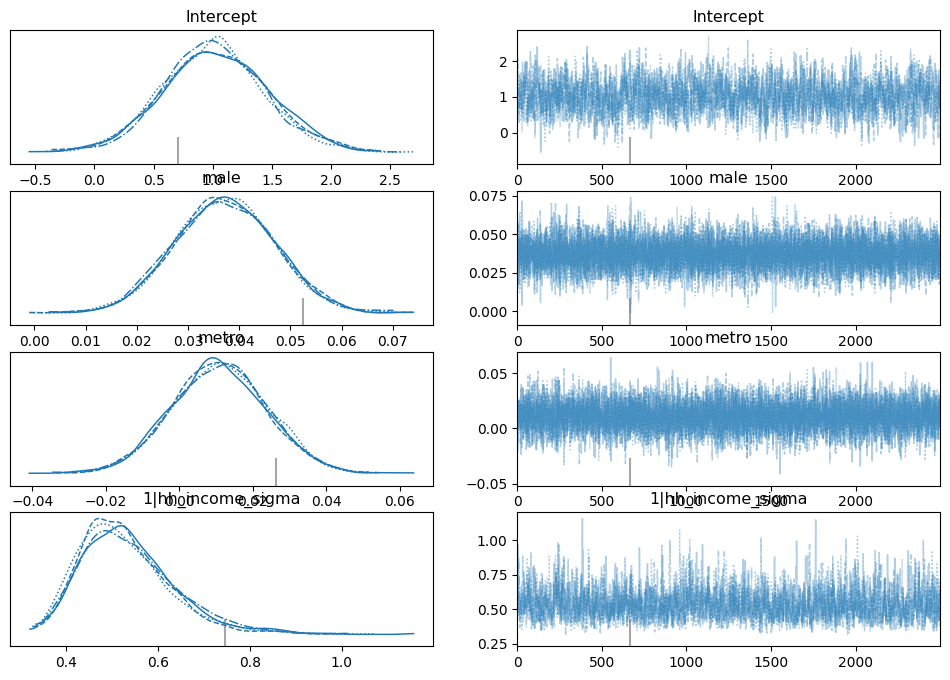

In [23]:
az.plot_trace(
    pr_asset_model_idata,
    var_names=["Intercept", "male", "metro", "1|hh_income_sigma"],
)

array([<Axes: title={'center': 'metro'}>,
       <Axes: title={'center': 'male'}>,
       <Axes: title={'center': 'citizen'}>], dtype=object)

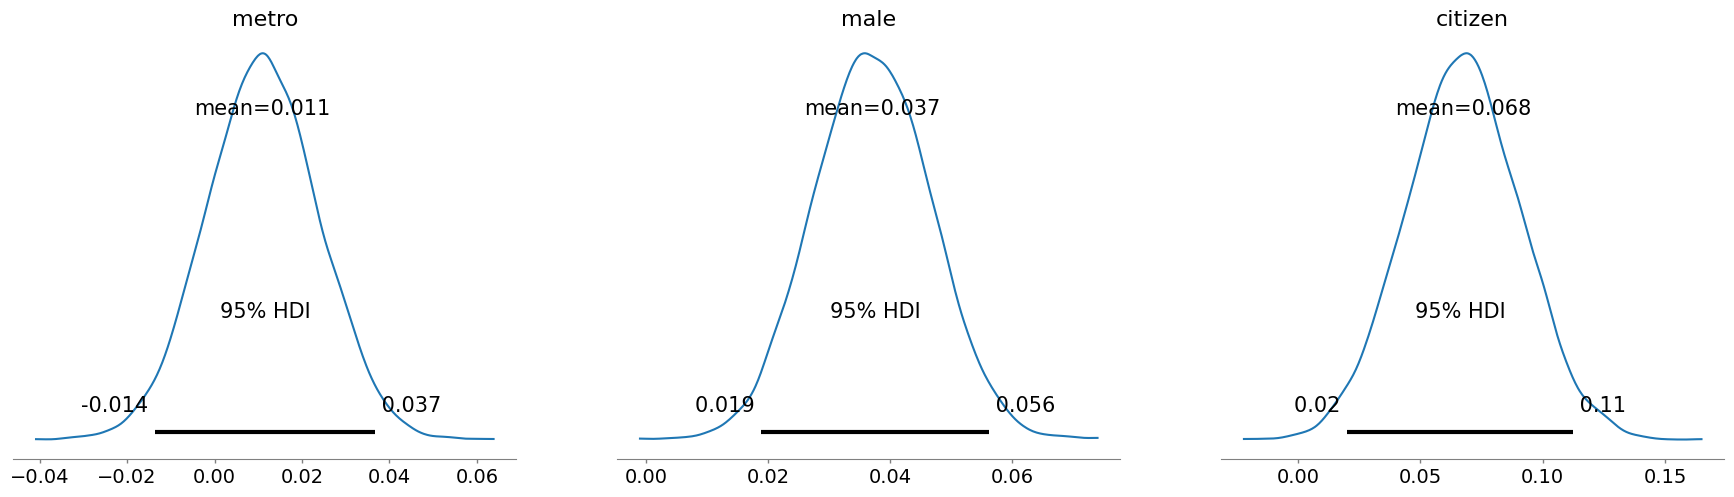

In [24]:
az.plot_posterior(
    pr_asset_model_idata,
    var_names=["metro", "male", "citizen"],
    hdi_prob=0.95
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

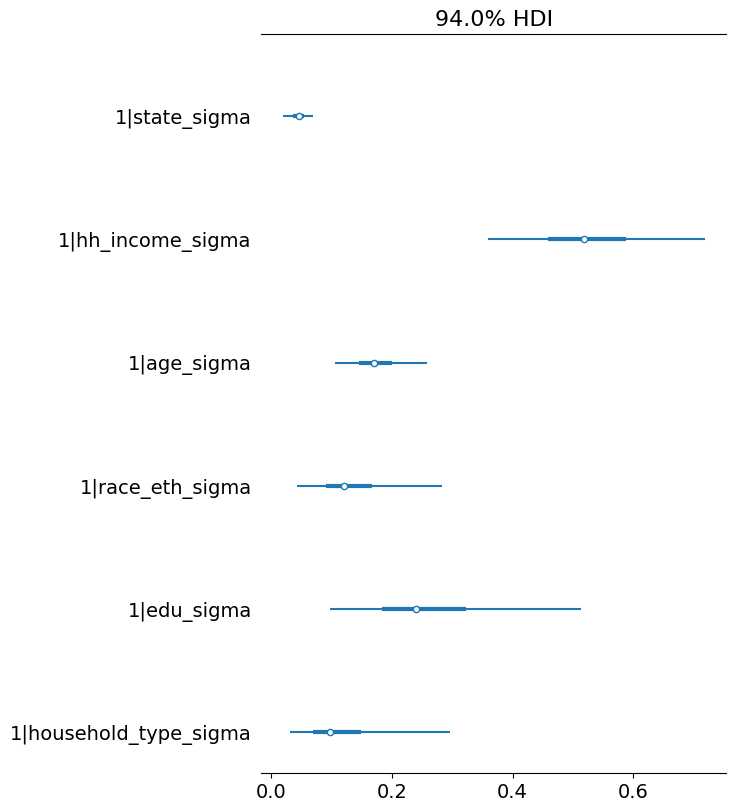

In [25]:
az.plot_forest(
    pr_asset_model_idata,
    var_names=["1|state_sigma",
               "1|hh_income_sigma",
               "1|age_sigma",
               "1|race_eth_sigma",
               "1|edu_sigma",
               "1|household_type_sigma"],
    combined=True,
)


## Percent Rank Debt Model

In [44]:
pr_debt_model_cols = ['prank_debts',
'state',
'hh_income',
'age',
'race_eth',
'edu',
'tenure',
'household_type',
'male',
'metro',
'disability',
'class_worker',
'public_assistance',
'social_security',
'poverty',
'citizen',
'english_at_home',
'homevalue',
'race_eth_state',	
'race_eth_edu',	
'race_eth_age',	
'race_eth_income']

In [45]:
pr_debt_model_df = sipp_model.select(pl.col(pr_debt_model_cols)).to_pandas().dropna(subset=pr_debt_model_cols)
pr_debt_model_df

,prank_debts,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,...,public_assistance,social_security,poverty,citizen,english_at_home,homevalue,race_eth_state,race_eth_edu,race_eth_age,race_eth_income
1,0.531261,20,8,5,1,3,2,4,0,1,...,0,0,0,1,1,4,1:20,1:3,1:5,1:8
3,0.418817,20,10,11,1,2,2,2,0,1,...,0,1,0,1,1,3,1:20,1:2,1:11,1:10
7,0.241768,20,8,3,3,4,3,2,1,1,...,0,0,0,0,0,1,3:20,3:4,3:3,3:8
8,0.253933,20,6,9,1,4,3,2,1,1,...,0,0,0,1,1,1,1:20,1:4,1:9,1:6
9,0.077989,40,2,2,1,2,3,4,1,0,...,0,0,1,1,1,1,1:40,1:2,1:2,1:2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26167,0.471261,6,3,7,4,3,1,4,0,1,...,0,0,1,1,1,6,4:6,4:3,4:7,4:3
26168,0.943090,6,13,9,3,1,2,2,1,1,...,0,0,0,1,0,6,3:6,3:1,3:9,3:13
26170,0.932720,6,12,7,4,3,2,1,1,1,...,0,1,0,1,0,6,4:6,4:3,4:7,4:12
26171,0.015840,6,9,9,4,1,1,2,1,1,...,0,1,0,1,0,6,4:6,4:1,4:9,4:9


In [46]:
# since using beta family and min value is 0.000000 squish values to avoid any values that are exactly 0 or 1
eps = 1e-6
pr_debt_model_df["prank_debts_adj"] = np.clip(pr_debt_model_df["prank_debts"], eps, 1 - eps)

In [47]:
pr_debt_model_df.describe()

,prank_debts,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,disability,class_worker,public_assistance,social_security,poverty,citizen,english_at_home,homevalue,prank_debts_adj
count,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000
mean,0.490756,27.950034,10.321637,7.936896,1.637660,3.074107,2.138165,2.600157,0.490624,0.835616,0.249439,3.403997,0.056703,0.307321,0.113463,0.949753,0.879239,3.234617,0.490756
std,0.286781,16.317810,4.422879,3.207014,1.049541,1.168720,0.685557,1.189201,0.499926,0.370634,0.432700,0.950189,0.231281,0.461396,0.317167,0.218460,0.325859,1.836421,0.286781
min,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000001
25%,0.242953,12.000000,7.000000,5.000000,1.000000,2.000000,2.000000,2.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.242953
50%,0.489045,28.000000,10.000000,8.000000,1.000000,3.000000,2.000000,2.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000,0.489045
75%,0.733769,42.000000,14.000000,10.000000,2.000000,4.000000,3.000000,4.000000,1.000000,1.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,4.000000,0.733769
max,0.999936,56.000000,18.000000,15.000000,5.000000,5.000000,3.000000,4.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,0.999936


In [50]:
pr_debt_model_df

,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,disability,...,social_security,poverty,citizen,english_at_home,homevalue,race_eth_state,race_eth_edu,race_eth_age,race_eth_income,prank_debts_adj
1,20,8,5,1,3,2,4,0,1,0,...,0,0,1,1,4,1:20,1:3,1:5,1:8,0.531261
3,20,10,11,1,2,2,2,0,1,0,...,1,0,1,1,3,1:20,1:2,1:11,1:10,0.418817
7,20,8,3,3,4,3,2,1,1,0,...,0,0,0,0,1,3:20,3:4,3:3,3:8,0.241768
8,20,6,9,1,4,3,2,1,1,1,...,0,0,1,1,1,1:20,1:4,1:9,1:6,0.253933
9,40,2,2,1,2,3,4,1,0,0,...,0,1,1,1,1,1:40,1:2,1:2,1:2,0.077989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26167,6,3,7,4,3,1,4,0,1,0,...,0,1,1,1,6,4:6,4:3,4:7,4:3,0.471261
26168,6,13,9,3,1,2,2,1,1,0,...,0,0,1,0,6,3:6,3:1,3:9,3:13,0.943090
26170,6,12,7,4,3,2,1,1,1,1,...,1,0,1,0,6,4:6,4:3,4:7,4:12,0.932720
26171,6,9,9,4,1,1,2,1,1,1,...,1,0,1,0,6,4:6,4:1,4:9,4:9,0.015840


In [49]:
pr_debt_model_df.drop(['prank_debts'],axis=1,inplace=True)

In [51]:
for col in ['state','hh_income','age','race_eth','edu','tenure',
            'household_type','class_worker','homevalue','race_eth_state',
            'race_eth_edu',	'race_eth_age',	'race_eth_income']:
    pr_debt_model_df[col] = pr_debt_model_df[col].astype('category')

In [52]:
pr_debt_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17812 entries, 1 to 26172
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   state              17812 non-null  category
 1   hh_income          17812 non-null  category
 2   age                17812 non-null  category
 3   race_eth           17812 non-null  category
 4   edu                17812 non-null  category
 5   tenure             17812 non-null  category
 6   household_type     17812 non-null  category
 7   male               17812 non-null  int32   
 8   metro              17812 non-null  int8    
 9   disability         17812 non-null  int32   
 10  class_worker       17812 non-null  category
 11  public_assistance  17812 non-null  int8    
 12  social_security    17812 non-null  int8    
 13  poverty            17812 non-null  int8    
 14  citizen            17812 non-null  int32   
 15  english_at_home    17812 non-null  int32   
 16  homevalue

In [53]:
# change tenure from random effect to fixed effect
pr_debt_model_formula = """
prank_debts_adj ~ male + metro + disability + class_worker + public_assistance
            + social_security + poverty + citizen + english_at_home + homevalue
            + tenure
            + (1|state) + (1|hh_income) + (1|age) + (1|race_eth) + (1|edu)
            + (1|household_type)
            + (1|race_eth:state) + (1|race_eth:edu) + (1|race_eth:age) + (1|race_eth:hh_income)
"""

In [54]:
pr_debt_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "group_specific": bmb.Prior(
        "Normal",
        mu=0,
        sigma=bmb.Prior("Exponential", lam=1),
    )
}

In [55]:
pr_debt_model = bmb.Model(formula=pr_debt_model_formula, 
                            data=pr_debt_model_df, 
                            family="beta",
                            link='logit',
                            priors=pr_debt_priors,
                            noncentered=True)

In [56]:
pr_debt_model_idata = pr_debt_model.fit(draws=2500,
                                          tune=2500,
                                          chains=4,
                                          target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, Intercept, male, metro, disability, class_worker, public_assistance, social_security, poverty, citizen, english_at_home, homevalue, tenure, 1|state_sigma, 1|state_offset, 1|hh_income_sigma, 1|hh_income_offset, 1|age_sigma, 1|age_offset, 1|race_eth_sigma, 1|race_eth_offset, 1|edu_sigma, 1|edu_offset, 1|household_type_sigma, 1|household_type_offset, 1|race_eth:state_sigma, 1|race_eth:state_offset, 1|race_eth:edu_sigma, 1|race_eth:edu_offset, 1|race_eth:age_sigma, 1|race_eth:age_offset, 1|race_eth:hh_income_sigma, 1|race_eth:hh_income_offset]


Output()

Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 14122 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [57]:
az.to_netcdf(pr_debt_model_idata,r'models/pr_debt_model_20260216.nc')

'models/pr_debt_model_20260216.nc'

In [63]:
pr_debt_model_summ = az.summary(pr_debt_model_idata, var_names=["Intercept", "male", "metro","disability",'class_worker','public_assistance',
                                                                  'social_security',"poverty","citizen",'english_at_home','homevalue',
                                                                  'tenure'], round_to=3)
pr_debt_model_summ[["mean","sd","hdi_3%","hdi_97%","r_hat","ess_bulk","ess_tail"]]


,mean,sd,hdi_3%,hdi_97%,r_hat,ess_bulk,ess_tail
Intercept,-0.300,0.388,-1.026,0.432,1.002,2696.172,4787.894
male,-0.006,0.014,-0.031,0.020,1.000,26547.212,7225.169
metro,-0.010,0.019,-0.044,0.026,1.000,23876.368,7279.276
disability,0.064,0.017,0.031,0.096,1.000,25537.442,7543.152
class_worker[2.0],-0.319,0.046,-0.409,-0.235,1.000,10865.362,7971.062
class_worker[3.0],-0.444,0.038,-0.517,-0.373,1.000,10899.585,7660.091
class_worker[4.0],-0.487,0.049,-0.581,-0.397,1.000,10297.168,8428.069
class_worker[5.0],-0.389,0.042,-0.464,-0.307,1.000,10844.129,7922.175
public_assistance,-0.041,0.029,-0.097,0.012,1.000,24153.824,7350.440
social_security,-0.013,0.024,-0.057,0.031,1.001,15878.939,7386.924


In [64]:
post_vars = list(pr_debt_model_idata.posterior.data_vars)
sd_like = [v for v in post_vars if ("sigma" in v.lower()) or ("sd" in v.lower())]
summ_sd = az.summary(pr_debt_model_idata, var_names=sd_like, round_to=3)
summ_sd

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|state_sigma,0.029,0.016,0.000,0.054,0.000,0.000,1692.011,4145.147,1.000
1|hh_income_sigma,0.297,0.059,0.198,0.406,0.001,0.001,3332.806,5303.804,1.001
1|age_sigma,0.137,0.043,0.064,0.217,0.001,0.001,4113.172,4694.900,1.001
1|race_eth_sigma,0.037,0.038,0.000,0.098,0.000,0.001,6039.463,7046.009,1.000
1|edu_sigma,0.207,0.123,0.062,0.408,0.002,0.004,5569.157,6095.950,1.001
1|household_type_sigma,0.127,0.105,0.031,0.286,0.002,0.006,6204.609,5943.527,1.000
1|race_eth:state_sigma,0.044,0.013,0.019,0.068,0.000,0.000,1989.222,2232.487,1.002
1|race_eth:edu_sigma,0.070,0.020,0.036,0.109,0.000,0.000,4708.753,7080.204,1.000
1|race_eth:age_sigma,0.062,0.017,0.032,0.095,0.000,0.000,3419.124,5707.610,1.000
1|race_eth:hh_income_sigma,0.037,0.018,0.000,0.065,0.000,0.000,2434.768,3395.436,1.001


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'male'}>,
        <Axes: title={'center': 'male'}>],
       [<Axes: title={'center': 'metro'}>,
        <Axes: title={'center': 'metro'}>],
       [<Axes: title={'center': '1|hh_income_sigma'}>,
        <Axes: title={'center': '1|hh_income_sigma'}>]], dtype=object)

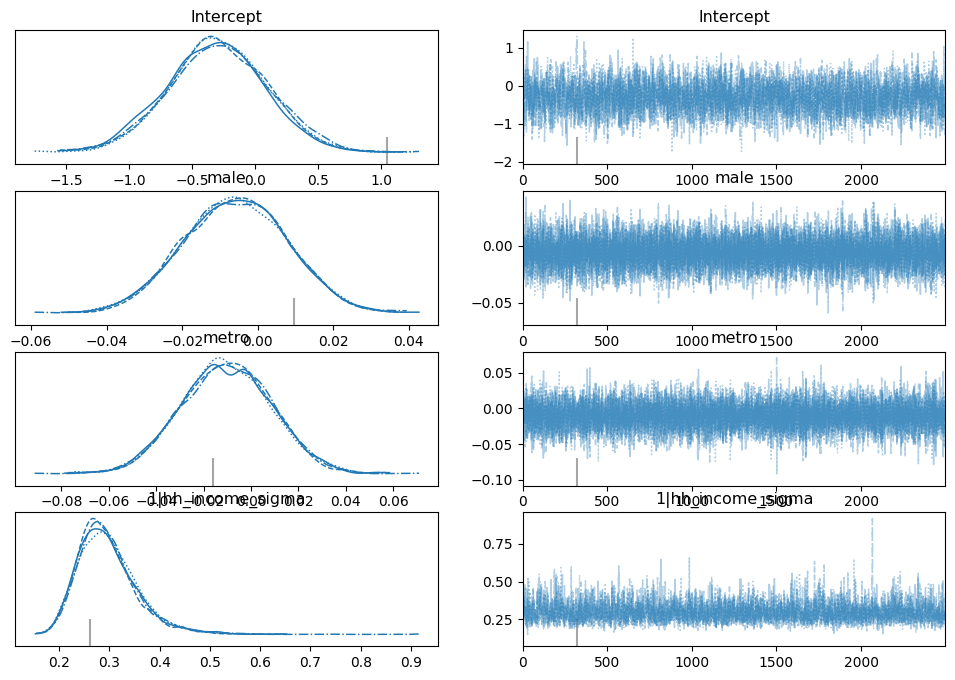

In [65]:
az.plot_trace(
    pr_debt_model_idata,
    var_names=["Intercept", "male", "metro", "1|hh_income_sigma"],
)

array([<Axes: title={'center': 'metro'}>,
       <Axes: title={'center': 'male'}>,
       <Axes: title={'center': 'citizen'}>], dtype=object)

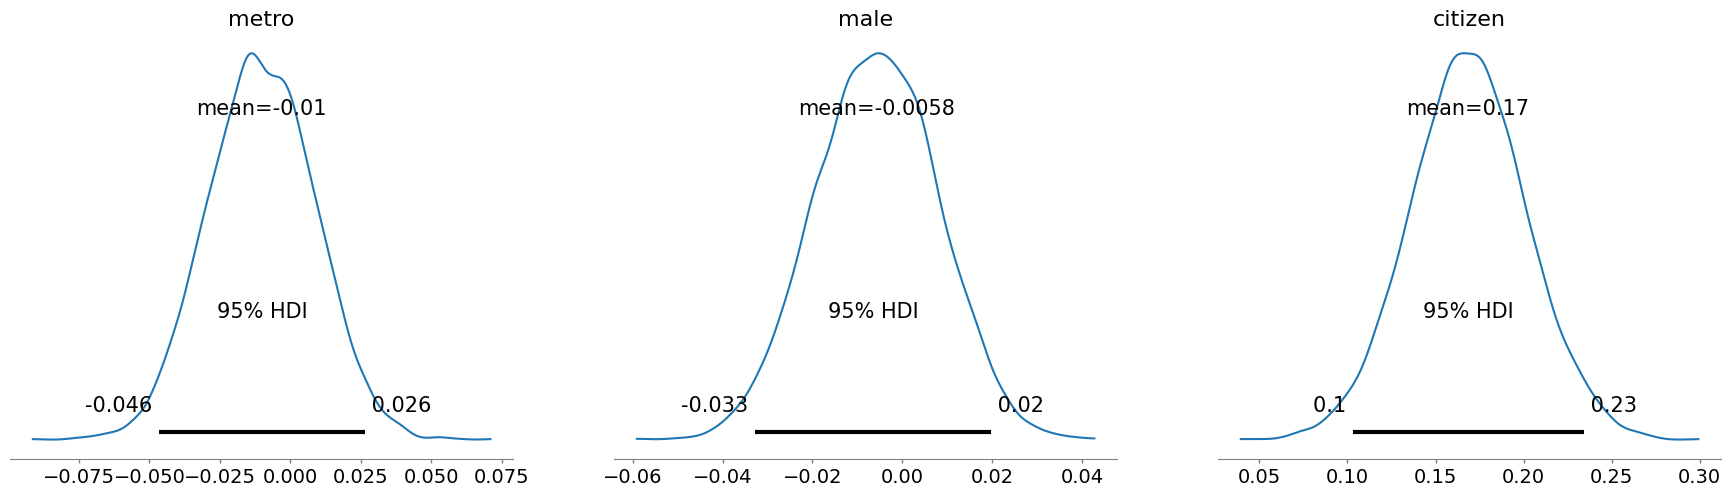

In [66]:
az.plot_posterior(
    pr_debt_model_idata,
    var_names=["metro", "male", "citizen"],
    hdi_prob=0.95
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

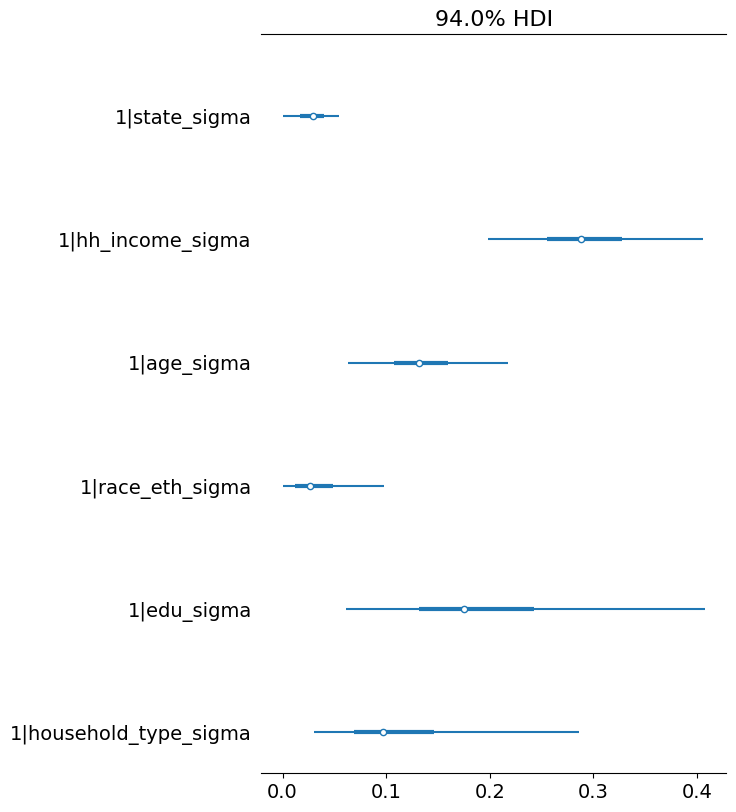

In [67]:
az.plot_forest(
    pr_debt_model_idata,
    var_names=["1|state_sigma",
               "1|hh_income_sigma",
               "1|age_sigma",
               "1|race_eth_sigma",
               "1|edu_sigma",
               "1|household_type_sigma"],
    combined=True,
)
